In [1]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import os
import time


from lab2_tools import *
from lab2_proto import *

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

# The variable data and example are arrays of dictionaries. Each element contains the following keys:

# filename: filename of the wave file in the database
# samplingrate: sampling rate of the speech signal (20kHz in all examples) 
# gender: gender of the speaker for the current utterance (man, woman) 
# speaker: speaker ID for the current utterance (ae, ac)
# digit: digit contained in the current utterance (o, z, 1, ..., 9) 
# repetition: whether this was the first (a) or second (b) repetition
# samples: array of speech samples
# lmfcc: liftered Mel Frequency Cepstrum Coefficients
# ----------------------- For example only -----------------------
# obsloglik: observation log likelihood for each Gaussian in wordHMMs['o'], shape: (n_timesteps, n_states)
# logalpha: alpha log probabilities, see definition later, shape: (n_timesteps, n_states)
# logbeta: beta log probabilities, see definition later, shape: (n_timesteps, n_states)
# loglik: log likelihood of the observations sequence X given the HMM model, scalar
# vloglik: Viterbi log likelihood of the observations sequence X and the best path given the HMM model, scalar
# loggamma: gamma log probabilities, see definition later, shape: (n_timesteps, n_states)
# logxi: xi log probabilities, see definition later, shape: (n_timesteps, n_states)

In [3]:
# trained on the full training set
# phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

# trained on a single speaker, that happens to be female
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

# phoneHMMs is a dictionary with 21 keys, each corresponding to a phonetic model
list(sorted(phoneHMMs.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [4]:
phoneHMMs['ah'].keys()
# name: phonetic symbol, sil(silence) or sp(short pauses)
# startprob: probability to start in state i, size: [4,]
# transmat: transition probability from state i to j, size: [4, 4]
# means: [3, 13] array of mean vectors (rows correspond to different states)
# covars: [3, 13] array of variance vectors (rows correspond to different states)

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

In [5]:
from prondict import *

# Because we are working with recordings of isolated digits, 
# a model of each utterance should also contain initial and final silence
isolated = {}
wordHMMs = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs[digit] = concatHMMs(phoneHMMs, isolated[digit])

# Gaussian emission probabilities

obsloglik is checked


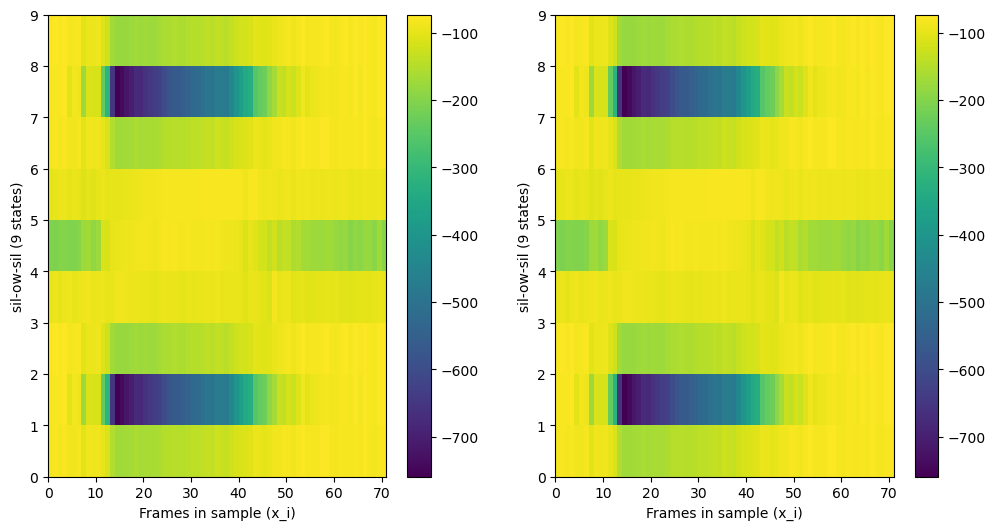

In [6]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
if np.allclose(obsloglik, example["obsloglik"]):
    print("obsloglik is checked")

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pcolormesh(obsloglik.T)
plt.colorbar()
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.pcolormesh(example['obsloglik'].T)
plt.colorbar()
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.show()

### Plot the log likelihood for Gaussians from HMMs models corresponding to the same digit on a test utterance of your choice.

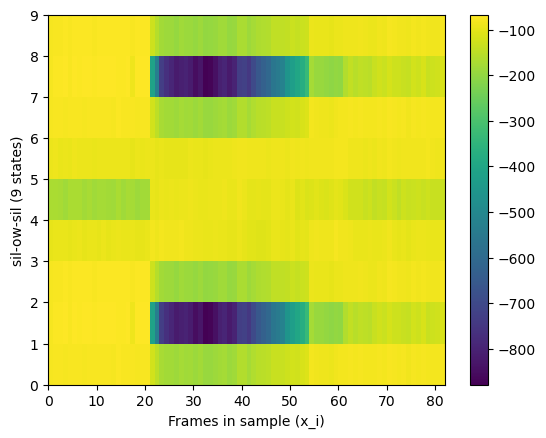

In [7]:
# Find the index of the first dictionary in data where the key ['digit'] has the value 'o'
for index, dictionary in enumerate(data):
    if dictionary.get('digit') == 'o':
        break
obsloglik_test = log_multivariate_normal_density_diag(data[index]['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  

plt.pcolormesh(obsloglik_test.T)
plt.colorbar()
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.show()

### What can you say about the figure? 
Usually we model 3 segments for each phoneme, such that each phoneme's model is made of 3 states. So the word model on 'o' is made of 3 phoneme models of 'ow' and 2 'sil' in the start and end, making it 9 states in total.

The frames in the beginning and the end of the sample should be silent and the middle frames should correspond to the word 'o'.

### Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence.
According to the color bar, the state with higher probability is shown in yellow.

Although it does not have clear discrimination, it can still be roughly seen that the probability of state 4 before frame 20 and after frame 55 is very low, which corresponds to the pronunciation of 'o'. On the contrary, the probability of state 4 is significantly increased inside this interval. 

The probabilities of state 0 and 7 are also relatively high inside frame 20~55, which corresponds to silence.

# Forward Algorithm

/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/3223459321.py:1: RuntimeWarning: divide by zero encountered in log
  log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/3223459321.py:2: RuntimeWarning: divide by zero encountered in log
  log_transmat = np.log(wordHMMs['o']['transmat'][:-1, :-1])


logalpha is checked


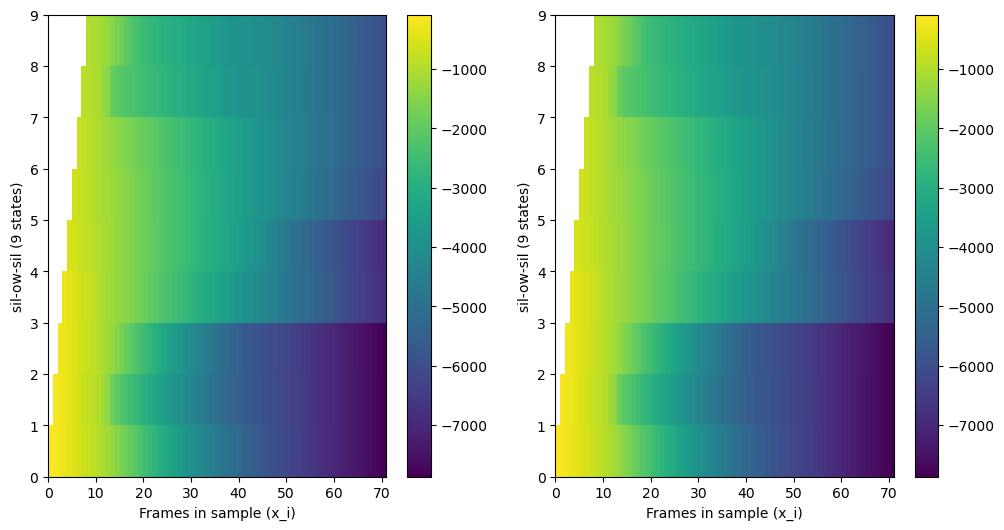

In [8]:
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1, :-1])
# Find the probability that the model has generated the sequence of observations
logalpha = forward(obsloglik, log_startprob, log_transmat) 
if np.allclose(logalpha, example["logalpha"]):
    print("logalpha is checked")

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pcolormesh(logalpha.T)
plt.colorbar()
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.pcolormesh(example['logalpha'].T)
plt.colorbar()
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.show()

In [9]:
# last coloum in logalpha gives all observations 
loglik = logsumexp(logalpha[-1])
if np.allclose(loglik, example["loglik"]):
    print("loglik is checked")

loglik is checked


### Score all the 44 utterances in the data array with each of the 11 HMM models in wordHMMs, and take the maximum likelihood model as winner (trained on the full training set).

In [10]:
# trained on the full training set
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
for digit in prondict.keys():
    wordHMMs[digit] = concatHMMs(phoneHMMs, isolated[digit])

prediction = []
for utterance in data:
    loglik_list = []
    for digit in prondict.keys():
        obsloglik_test = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars']) 
        log_startprob_test = np.log(wordHMMs[digit]['startprob'][:-1])
        log_transmat_test = np.log(wordHMMs[digit]['transmat'][:-1, :-1]) 
        logalpha_test = forward(obsloglik_test, log_startprob_test, log_transmat_test)
        loglik_test = logsumexp(logalpha_test[-1])
        loglik_list.append(loglik_test)
    max_index = loglik_list.index(max(loglik_list))
    prediction.append(data[max_index]['digit'])

mistake = 0
for i, (pred, d) in enumerate(zip(prediction, data)):
    true_value = d['digit']
    if pred != true_value:
        mistake += 1
        print(f"Index: {i}, Prediction: {pred}, True Value: {true_value}")
print(f"Number of mistakes: {mistake}")    

/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/2658331363.py:11: RuntimeWarning: divide by zero encountered in log
  log_startprob_test = np.log(wordHMMs[digit]['startprob'][:-1])
/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/2658331363.py:12: RuntimeWarning: divide by zero encountered in log
  log_transmat_test = np.log(wordHMMs[digit]['transmat'][:-1, :-1])


Index: 2, Prediction: o, True Value: z
Index: 3, Prediction: o, True Value: z
Index: 4, Prediction: z, True Value: 1
Index: 5, Prediction: z, True Value: 1
Index: 6, Prediction: z, True Value: 2
Index: 7, Prediction: z, True Value: 2
Index: 8, Prediction: 1, True Value: 3
Index: 9, Prediction: 1, True Value: 3
Index: 10, Prediction: 1, True Value: 4
Index: 11, Prediction: 1, True Value: 4
Index: 12, Prediction: 2, True Value: 5
Index: 13, Prediction: 2, True Value: 5
Index: 14, Prediction: 2, True Value: 6
Index: 15, Prediction: 2, True Value: 6
Index: 16, Prediction: 3, True Value: 7
Index: 17, Prediction: 3, True Value: 7
Index: 18, Prediction: 3, True Value: 8
Index: 19, Prediction: 3, True Value: 8
Index: 20, Prediction: 4, True Value: 9
Index: 21, Prediction: 4, True Value: 9
Index: 24, Prediction: o, True Value: z
Index: 25, Prediction: o, True Value: z
Index: 26, Prediction: z, True Value: 1
Index: 27, Prediction: z, True Value: 1
Index: 28, Prediction: z, True Value: 2
Index: 2

### Score all the 44 utterances in the data array with each of the 11 HMM models in wordHMMs, and take the maximum likelihood model as winner (trained on a single speaker, that happens to be female).

In [11]:
start_cpu = os.times()[0] + os.times()[1]  # user time + system time


# trained on a single speaker, that happens to be female
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
for digit in prondict.keys():
    wordHMMs[digit] = concatHMMs(phoneHMMs, isolated[digit])

prediction = []
for utterance in data:
    loglik_list = []
    for digit in prondict.keys():
        obsloglik_test = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars']) 
        log_startprob_test = np.log(wordHMMs[digit]['startprob'][:-1])
        log_transmat_test = np.log(wordHMMs[digit]['transmat'][:-1, :-1]) 
        logalpha_test = forward(obsloglik_test, log_startprob_test, log_transmat_test)
        loglik_test = logsumexp(logalpha_test[-1])
        loglik_list.append(loglik_test)
    max_index = loglik_list.index(max(loglik_list))
    prediction.append(data[max_index]['digit'])

mistake = 0
for i, (pred, d) in enumerate(zip(prediction, data)):
    true_value = d['digit']
    if pred != true_value:
        mistake += 1
        print(f"Index: {i}, Prediction: {pred}, True Value: {true_value}")
print(f"Number of mistakes: {mistake}")


end_cpu = os.times()[0] + os.times()[1]
cpu_usage = end_cpu - start_cpu
print("\n\n")
print(f"CPU Usage: {cpu_usage:.2f} seconds")

/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/3724846543.py:14: RuntimeWarning: divide by zero encountered in log
  log_startprob_test = np.log(wordHMMs[digit]['startprob'][:-1])
/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/3724846543.py:15: RuntimeWarning: divide by zero encountered in log
  log_transmat_test = np.log(wordHMMs[digit]['transmat'][:-1, :-1])


Index: 2, Prediction: o, True Value: z
Index: 3, Prediction: o, True Value: z
Index: 5, Prediction: 4, True Value: 1
Index: 6, Prediction: 1, True Value: 2
Index: 7, Prediction: z, True Value: 2
Index: 8, Prediction: 1, True Value: 3
Index: 9, Prediction: 1, True Value: 3
Index: 10, Prediction: 1, True Value: 4
Index: 11, Prediction: 1, True Value: 4
Index: 12, Prediction: 1, True Value: 5
Index: 13, Prediction: 1, True Value: 5
Index: 14, Prediction: 2, True Value: 6
Index: 15, Prediction: 2, True Value: 6
Index: 16, Prediction: 1, True Value: 7
Index: 17, Prediction: 1, True Value: 7
Index: 18, Prediction: 1, True Value: 8
Index: 19, Prediction: 1, True Value: 8
Index: 20, Prediction: 4, True Value: 9
Index: 21, Prediction: o, True Value: 9
Index: 24, Prediction: o, True Value: z
Index: 25, Prediction: o, True Value: z
Index: 26, Prediction: z, True Value: 1
Index: 27, Prediction: z, True Value: 1
Index: 28, Prediction: z, True Value: 2
Index: 29, Prediction: z, True Value: 2
Index: 

# Viterbi Approximation

In [12]:
# Fine the most likely state sequence given the observation sequence
vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)

if np.allclose(vloglik, example['vloglik']):
    print("vloglik is checked")
if np.allclose(vpath, example['vpath']):
    print("vpath is checked")

vloglik is checked
vpath is checked


### Plot the alpha array that you obtained in the previous Section and overlay the best path obtained by Viterbi decoding. Can you explain the reason why the path looks this way?

The path shows the change of states, which can also be considered as the change of segments between each phoneme.

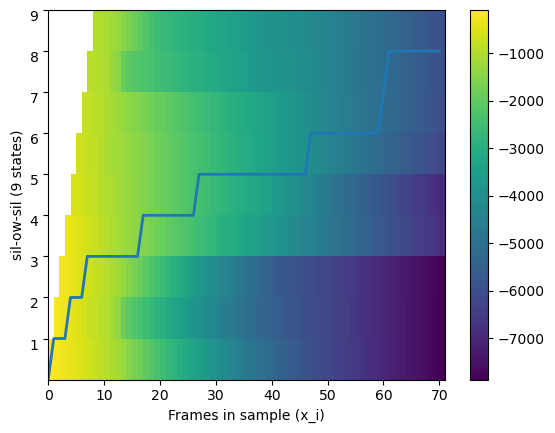

[0 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 8 8 8 8 8 8 8 8 8]


In [13]:
plt.figure()
plt.pcolormesh(np.ma.masked_array(logalpha.T))
plt.plot(vpath, linewidth = 2)
plt.colorbar()
plt.yticks(range(1,10), verticalalignment='top')
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.show()

print(vpath)

### Using the Viterbi algorithm, score all the 44 utterances in the data with each of the 11 HMM models in wordHMMs. How many mistakes can you count if you take as winner the model with the maximum viterbi score? Are these the same mistakes obtained in previous section?

We get 39 mistakes in our experiment, and they are the same mistakes obtained in previous section.

In [14]:
start_cpu = os.times()[0] + os.times()[1]  # user time + system time


# trained on a single speaker, that happens to be female
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
for digit in prondict.keys():
    wordHMMs[digit] = concatHMMs(phoneHMMs, isolated[digit])

prediction = []
for utterance in data:
    vloglik_list = []
    for digit in prondict.keys():
        obsloglik_test = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars']) 
        log_startprob_test = np.log(wordHMMs[digit]['startprob'][:-1])
        log_transmat_test = np.log(wordHMMs[digit]['transmat'][:-1, :-1]) 
        vloglik_test, vpath_test = viterbi(obsloglik_test, log_startprob_test, log_transmat_test)
        vloglik_list.append(vloglik_test)
    max_index = vloglik_list.index(max(vloglik_list))
    prediction.append(data[max_index]['digit'])

mistake = 0
for i, (pred, d) in enumerate(zip(prediction, data)):
    true_value = d['digit']
    if pred != true_value:
        mistake += 1
        print(f"Index: {i}, Prediction: {pred}, True Value: {true_value}")
print(f"Number of mistakes: {mistake}")


end_cpu = os.times()[0] + os.times()[1]
cpu_usage = end_cpu - start_cpu
print("\n\n")
print(f"CPU Usage: {cpu_usage:.2f} seconds")

/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/1504439916.py:14: RuntimeWarning: divide by zero encountered in log
  log_startprob_test = np.log(wordHMMs[digit]['startprob'][:-1])
/var/folders/n_/69h6zl_11r11127mr1z3n6zw0000gn/T/ipykernel_58654/1504439916.py:15: RuntimeWarning: divide by zero encountered in log
  log_transmat_test = np.log(wordHMMs[digit]['transmat'][:-1, :-1])


Index: 2, Prediction: o, True Value: z
Index: 3, Prediction: o, True Value: z
Index: 5, Prediction: 4, True Value: 1
Index: 6, Prediction: 1, True Value: 2
Index: 7, Prediction: z, True Value: 2
Index: 8, Prediction: 1, True Value: 3
Index: 9, Prediction: 1, True Value: 3
Index: 10, Prediction: 1, True Value: 4
Index: 11, Prediction: 1, True Value: 4
Index: 12, Prediction: 1, True Value: 5
Index: 13, Prediction: 1, True Value: 5
Index: 14, Prediction: 2, True Value: 6
Index: 15, Prediction: 2, True Value: 6
Index: 16, Prediction: 1, True Value: 7
Index: 17, Prediction: 1, True Value: 7
Index: 18, Prediction: 1, True Value: 8
Index: 19, Prediction: 1, True Value: 8
Index: 20, Prediction: 4, True Value: 9
Index: 21, Prediction: o, True Value: 9
Index: 24, Prediction: o, True Value: z
Index: 25, Prediction: o, True Value: z
Index: 26, Prediction: z, True Value: 1
Index: 27, Prediction: z, True Value: 1
Index: 28, Prediction: z, True Value: 2
Index: 29, Prediction: z, True Value: 2
Index: 

### Can you say something about the complexity of the viterbi scoring compared to the forward scoring (for example by measuring the CPU usage?)

When using forward scoring, the time of CPU usage is 5.45 seconds

When using viterbi scoring, the time of CPU usage is 2.98 seconds

# Backward Algorithm

logbeta is checked


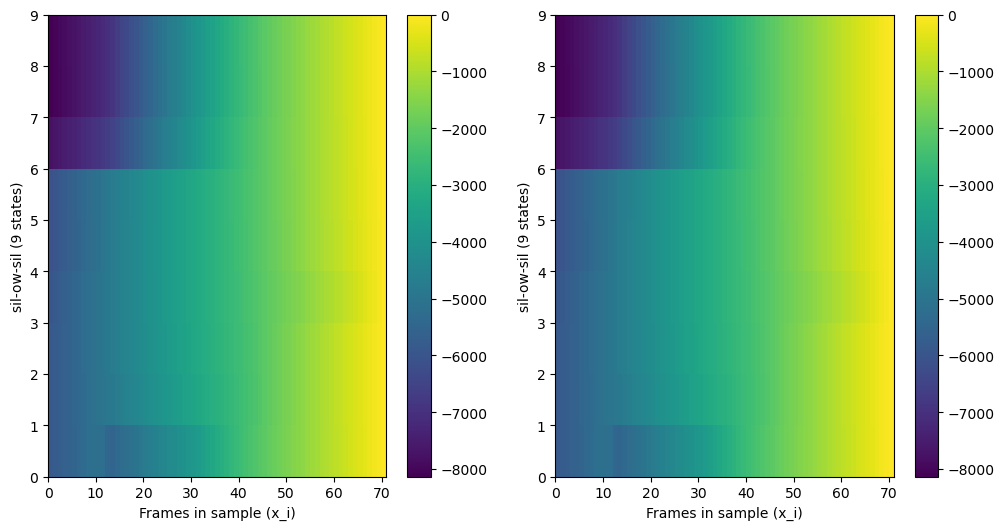

In [15]:
logbeta = backward(obsloglik, log_startprob, log_transmat) 
if np.allclose(logbeta, example["logbeta"]):
    print("logbeta is checked")

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pcolormesh(logbeta.T)
plt.colorbar()
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.pcolormesh(example['logbeta'].T)
plt.colorbar()
plt.xlabel('Frames in sample (x_i)')
plt.ylabel('sil-ow-sil (9 states)')
plt.show()

# State Posterior Probabilities

loggamma is checked


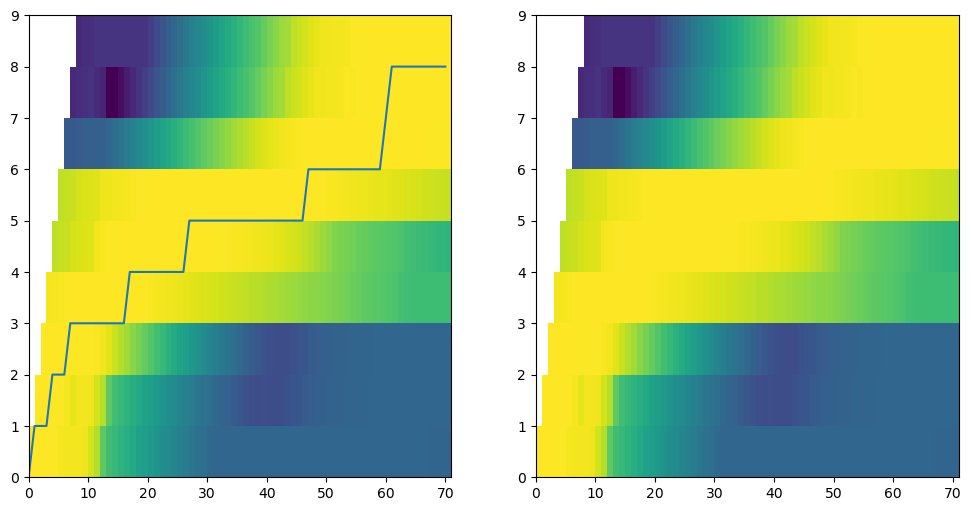

In [16]:
loggamma = statePosteriors(logalpha, logbeta)
if np.allclose(loggamma, example["loggamma"]):
    print("loggamma is checked")

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.pcolormesh(loggamma.T)
plt.plot(vpath)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.pcolormesh(example['loggamma'].T)
plt.show()

In [17]:
sum_ = np.sum(np.exp(loggamma), axis = 1)
sum_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

For each time step the state posteriors sum to one (in linear domain).

# Using this GMM model, compute the state posteriors for each time step in example utterance.

In [18]:
weights = np.full(9, 1/9)
gmmloglik_ = gmmloglik(obsloglik, weights)
gmmloglik_



-6037.6766640412725

#  Compare qualitatively the HMM and GMM posteriors. What is the difference? Why? 

# What is the effect of the transition model in the HMM combined with the more complex way of computing the state posteriors?

The transition model in HMMs captures the temporal dependencies between states, allowing the model to learn patterns of transitions through information about how the system evolves over time, hence improving the accuracy of the state posteriors and the overall performance of the HMM.

In [19]:
sum_2 = np.sum(np.exp(loggamma), axis = 0)
sum_2

array([ 1.34597458,  2.09555994,  3.55849998,  9.73752276, 10.12040999,
       20.5329264 , 12.9968938 ,  1.20869929,  9.40351326])

# What is the meaning the the values you obtain? 

Equal to the expectation of visiting that state  

In [20]:
sum_3 = np.sum(sum_2)
print(sum_3)
print(len(example['obsloglik']))

70.99999999991068
71


# What about summing over both states and time steps? Compare this number to the length of the observation sequence.

sum equals to 71, which is actually the length of the observation sequence (the number of frames)

# Retraining the Emission Probability Distributions

11


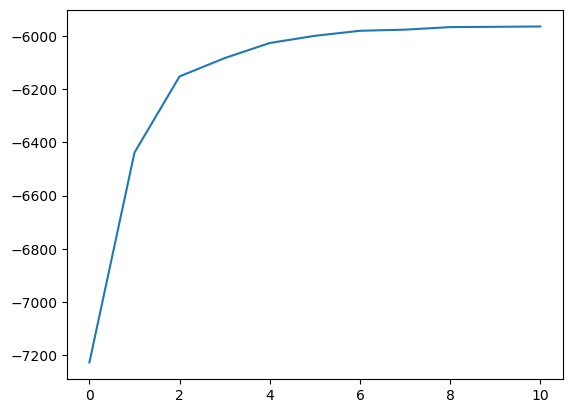

In [21]:
MAX_ITER = 20
digit = '4'
logliks = []
warnings.filterwarnings("ignore")

for t in range(MAX_ITER):
    obsloglik = log_multivariate_normal_density_diag(data[10]['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars'])
    
    #print(obsloglik)
    
    log_startprob = np.log(wordHMMs[digit]['startprob'][:-1])
    log_transmat = np.log(wordHMMs[digit]['transmat'][:-1, :-1])
    logalpha = forward(obsloglik, log_startprob, log_transmat) 
    
    #print(logalpha)
    
    logbeta = backward(obsloglik, log_startprob, log_transmat) 
    loggamma = statePosteriors(logalpha, logbeta)
    loglik = logsumexp(logalpha[-1])
    if(t!=0 and loglik < 1 + logliks[-1]):
        break
        
    logliks.append(loglik)
    
    wordHMMs[digit]['means'], wordHMMs[digit]['covars'] = updateMeanAndVar(data[10]['lmfcc'],loggamma)
    

plt.plot(logliks)


print(len(logliks))


7


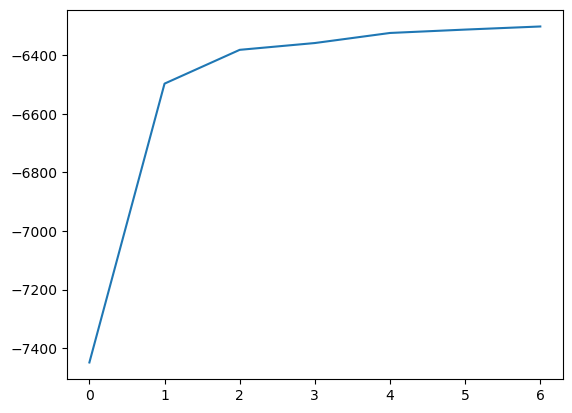

In [22]:
MAX_ITER = 20
digit = 'o'
logliks = []
warnings.filterwarnings("ignore")

for t in range(MAX_ITER):
    obsloglik = log_multivariate_normal_density_diag(data[10]['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars'])
    
    #print(obsloglik)
    
    log_startprob = np.log(wordHMMs[digit]['startprob'][:-1])
    log_transmat = np.log(wordHMMs[digit]['transmat'][:-1, :-1])
    logalpha = forward(obsloglik, log_startprob, log_transmat) 
    
    #print(logalpha)
    
    logbeta = backward(obsloglik, log_startprob, log_transmat) 
    loggamma = statePosteriors(logalpha, logbeta)
    loglik = logsumexp(logalpha[-1])
    if(t!=0 and loglik < 1 + logliks[-1]):
        break
        
    logliks.append(loglik)
    
    wordHMMs[digit]['means'], wordHMMs[digit]['covars'] = updateMeanAndVar(data[10]['lmfcc'],loggamma)
    

plt.plot(logliks)
print(len(logliks))

Well, it took a bit shorter to converge at last. And seems they do not converge to the same log likelihood.